In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import time

%matplotlib inline

In [2]:
img_1 = mpimg.imread("first_frame.png")
img_2 = mpimg.imread("second_frame.png")
img_3 = mpimg.imread("lighthouse.png")[:, :, 0]

In [46]:
def dft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    W = np.power( omega, i * j )
    return W

def idft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / N
    return W

def dft_2(I):
    (M, N) = I.shape
    
    W_N = dft_matrix(N)
    W_M = dft_matrix(M)
    
    It = np.zeros((M, N), dtype=complex)
    It = W_M@I@W_N
    return It

def idft_2(It):
    (M, N) = It.shape
    W_N = idft_matrix(N)
    W_M = idft_matrix(M)
    
    I = np.zeros((M, N), dtype=int)
    I = np.clip(np.real(W_M@It@W_N), 0, 255)
    return I

def linear_convolve_dft(f, h):
    (M, N) = f.shape
    (m, n) = h.shape
    
    h_padded = np.vstack((np.hstack((h, np.zeros((m, 2*N - n)))), np.zeros((2*M-m, 2*N))))
    f_padded = np.vstack((np.hstack((f, np.zeros((M, N)))), np.zeros((M, 2*N))))
    return idft_2(dft_2(h_padded) * dft_2(f_padded))[:M, :N]

def gaussian_filter(sigma, N):
    H = np.zeros((N, N))

    mid = N//2
    for i in range(N):
        for j in range(N):
            H[i, j] = np.exp(-2*np.power(np.pi*sigma, 2)*((mid-i)**2 + (mid-j)**2)/(N**2))
    return H/np.sum(H)

# Motion Estimation

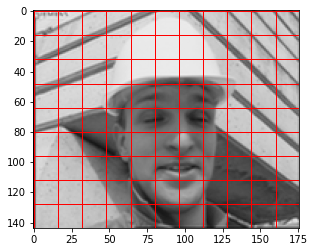

In [113]:
plt.imshow(img_1, cmap="gray")
for i in range(11):
    for j in range(9):
        plt.gca().add_patch(patches.Rectangle((16*i,16*j),16,16,linewidth=1,edgecolor='r',facecolor='none'))

In [244]:
def MAD(I, J, P, Q):
    return np.sum(np.absolute(I-J))/(P*Q)

def three_step_search(I, J, P, Q):
    M, N = I.shape
    m = M//P
    n = N//Q
    
    J_padded = np.zeros((M+2*P, N+2*Q))
    print(J_padded.shape)
    J_padded[P:(M+P), Q:(N+Q)] = J
    
    motion_vectors = dict()
    motion_vectors['k'] = []
    motion_vectors['k+1'] = []
    
    for i in range(m):
        for j in range(n):
            print("Block {}".format((i, j)))
            # Step 1
            metrics = dict()
            metrics['metric_1'] = []
            metrics['x_1'] = []
            metrics['y_1'] = []
            x_tuple = [-1, -1, -1, 0, 0, 1, 1, 1]
            y_tuple = [-1, 0, 1, -1, 1, -1, 0, 1]
            for k in range(8):
                x = x_tuple[k]
                y = y_tuple[k]
                I_x = P*i
                I_y = Q*j
                J_x = P*i + 4*x + P
                J_y = Q*j + 4*y + Q
                metrics['metric_1'].append(MAD(I[I_x:(I_x+P), I_y:(I_y+P)], J_padded[J_x:(J_x+P), J_y:(J_y+P)], P, Q))
                metrics['x_1'].append(J_x)
                metrics['y_1'].append(J_y)
            best_match_1_idx = np.argmin(metrics['metric_1'])
            print(metrics['metric_1'][best_match_1_idx])
            print(metrics['x_1'][best_match_1_idx], metrics['y_1'][best_match_1_idx])
            # Step 2
            metrics['metric_2'] = []
            metrics['x_2'] = []
            metrics['y_2'] = []
            x_tuple = [-1, -1, -1, 0, 0, 1, 1, 1, 0]
            y_tuple = [-1, 0, 1, -1, 1, -1, 0, 1, 0]
            for k in range(9):
                x = x_tuple[k]
                y = y_tuple[k]
                I_x = P*i
                I_y = Q*j
                J_x = metrics['x_1'][best_match_1_idx] + 2*x
                J_y = metrics['y_1'][best_match_1_idx] + 2*y
                metrics['metric_2'].append(MAD(I[I_x:(I_x+P), I_y:(I_y+P)], J_padded[J_x:(J_x+P), J_y:(J_y+P)], P, Q))
                metrics['x_2'].append(J_x)
                metrics['y_2'].append(J_y)
            best_match_2_idx = np.argmin(metrics['metric_2'])
            print(metrics['metric_2'][best_match_2_idx])
            print(metrics['x_2'][best_match_2_idx], metrics['y_2'][best_match_2_idx])
            # Step 3
            metrics['metric_3'] = []
            metrics['x_3'] = []
            metrics['y_3'] = []
            for k in range(9):
                x = x_tuple[k]
                y = y_tuple[k]
                I_x = P*i
                I_y = Q*j
                J_x = metrics['x_2'][best_match_2_idx] + x
                J_y = metrics['y_2'][best_match_2_idx] + y
                metrics['metric_3'].append(MAD(I[I_x:(I_x+P), I_y:(I_y+P)], J_padded[J_x:(J_x+P), J_y:(J_y+P)], P, Q))
                metrics['x_3'].append(metrics['x_2'][best_match_2_idx] + x)
                metrics['y_3'].append(metrics['y_2'][best_match_2_idx] + y)
            best_match_3_idx = np.argmin(metrics['metric_3'])
            print(metrics['metric_3'][best_match_3_idx])
            print(metrics['x_3'][best_match_3_idx], metrics['y_3'][best_match_3_idx])
            print()
            print("Best match {}->{}".format((P*i, Q*j), (metrics['x_3'][best_match_3_idx]-P, metrics['y_3'][best_match_3_idx]-Q)))
            print()
            motion_vectors['k'].append((P*i, Q*j))
            motion_vectors['k+1'].append((metrics['x_3'][best_match_3_idx]-P, metrics['y_3'][best_match_3_idx]-Q))
    return motion_vectors

In [245]:
P = 16
Q = 16
motion_vectors = three_step_search(img_1, img_2, P, Q)

(176, 208)
Block (0, 0)
0.1254289183707442
16 20
0.11040134573704563
16 18
0.08256740073557012
16 17

Best match (0, 0)->(0, 1)

Block (0, 1)
0.07849264238029718
16 36
0.05723038874566555
16 34
0.03561580670066178
16 33

Best match (0, 16)->(0, 17)

Block (0, 2)
0.06622242368757725
16 52
0.043382351053878665
16 50
0.024356616544537246
16 49

Best match (0, 32)->(0, 33)

Block (0, 3)
0.08491115143988281
16 60
0.0245710777817294
18 60
0.01833639678079635
18 59

Best match (0, 48)->(2, 43)

Block (0, 4)
0.0776041658828035
16 84
0.0495557599933818
16 82
0.02735906862653792
16 81

Best match (0, 64)->(0, 65)

Block (0, 5)
0.016850489424541593
16 100
0.013664215104654431
16 98
0.009129901533015072
16 97

Best match (0, 80)->(0, 81)

Block (0, 6)
0.04073222947772592
20 116
0.039322915486991405
18 114
0.033011642401106656
17 114

Best match (0, 96)->(1, 98)

Block (0, 7)
0.031678922940045595
20 132
0.02807904512155801
18 130
0.024065564735792577
17 129

Best match (0, 112)->(1, 113)

Block (0,

<ipython-input-251-358128353408>:20: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(J_y, J_x), xytext=(I_y, I_x), arrowprops=dict(arrowstyle='->'))


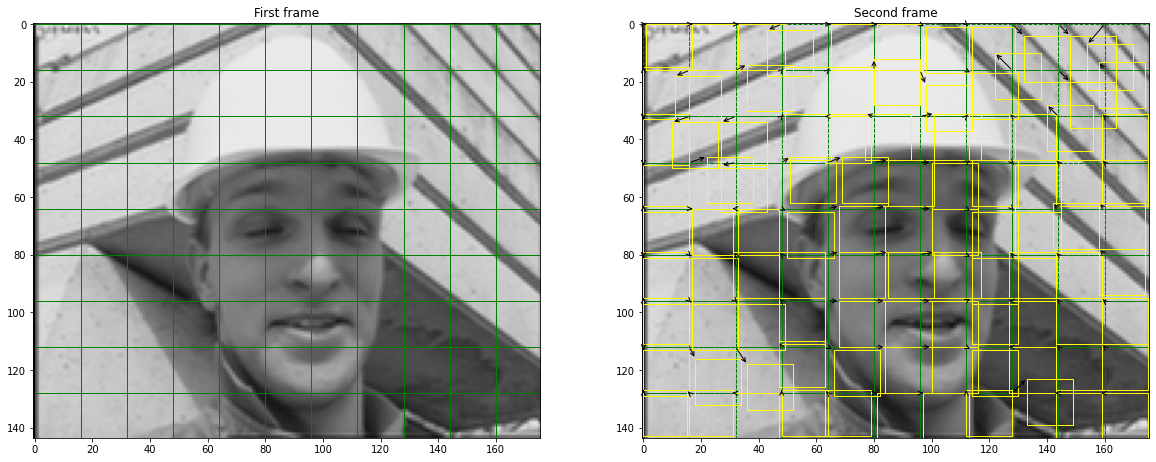

In [251]:
plt.rcParams["figure.figsize"] = (20, 16)

plt.subplot(1, 2, 1)
plt.title("First frame")
plt.imshow(img_1, cmap="gray")
for i in range(img_3.shape[1]//Q):
    for j in range(img_3.shape[0]//Q):
        plt.gca().add_patch(patches.Rectangle((P*i,Q*j),P,Q,linewidth=1,edgecolor='green',facecolor='none', linestyle='-'))

plt.subplot(1, 2, 2)
plt.title("Second frame")
plt.imshow(img_2, cmap="gray")
for i in range(img_3.shape[1]//Q):
    for j in range(img_3.shape[0]//Q):
        plt.gca().add_patch(patches.Rectangle((P*i,Q*j),P,Q,linewidth=1,edgecolor='green',facecolor='none', linestyle='--'))
for i in range(len(motion_vectors['k'])):
    (I_x, I_y) = motion_vectors['k'][i]
    (J_x, J_y) = motion_vectors['k+1'][i]
    plt.annotate(s='', xy=(J_y, J_x), xytext=(I_y, I_x), arrowprops=dict(arrowstyle='->'))
    plt.gca().add_patch(patches.Rectangle((J_y, J_x),P,Q,linewidth=1,edgecolor='yellow',facecolor='none', linestyle='-'))


In [260]:
def motion_compensated_predicated_frame(I, motion_vectors, P, Q):
    J = I.copy()
    for i in range(len(motion_vectors['k'])):
        J[motion_vectors['k+1'][i][0]:(motion_vectors['k+1'][i][0]+P), motion_vectors['k+1'][i][1]:(motion_vectors['k+1'][i][1]+Q)] = I[motion_vectors['k'][i][0]:(motion_vectors['k'][i][0]+P), motion_vectors['k'][i][1]:(motion_vectors['k'][i][1]+Q)]
    return J

In [263]:
J = motion_compensated_predicated_frame(img_1, motion_vectors, P, Q)

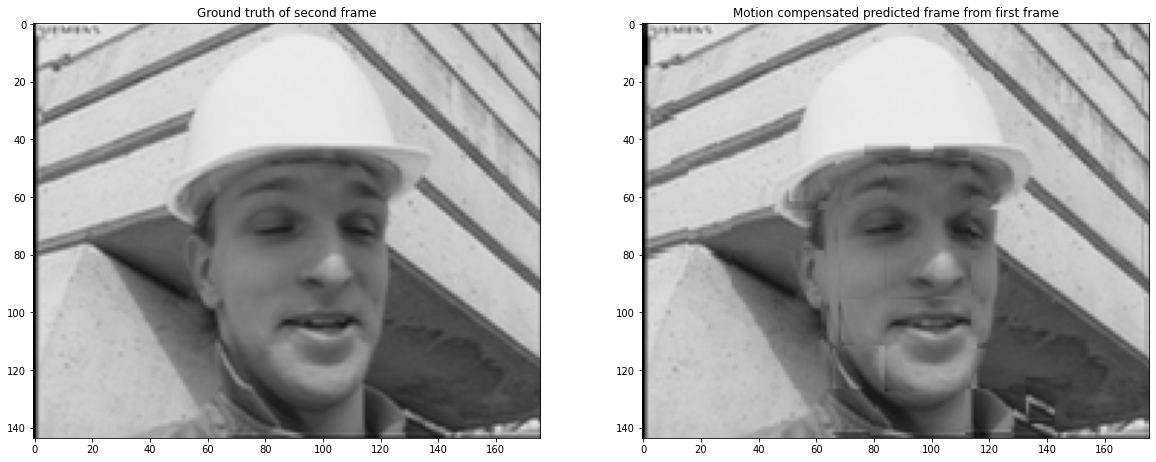

In [265]:
plt.subplot(1, 2, 1)
plt.title("Ground truth of second frame")
plt.imshow(img_2, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Motion compensated predicted frame from first frame")
plt.imshow(J, cmap="gray")

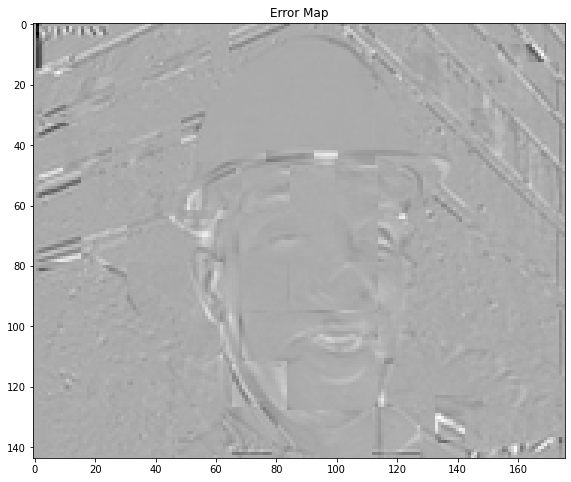

In [268]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.title("Error Map")
plt.imshow(J-img_2, cmap="gray")

# SSIM Index

In [4]:
def weights(P, Q):
    W = np.ones((P, Q))
    return W/(P*Q)

def luminance_similarity(I, J, P, Q, C1=(0.01*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    L = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            L[i, j] = (2*mu_i[i, j]*mu_j[i, j]+C1)/(mu_i[i, j]**2 + mu_j[i, j]**2 + C1)
    return L

def contrast_similarity(I, J, P, Q, C2=(0.03*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    sigma_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    sigma_j = np.zeros((M, N))
    C = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            sigma_i[i, j] = np.sqrt(np.sum(W*np.power(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j], 2)))
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            sigma_j[i, j] = np.sqrt(np.sum(W*np.power(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j], 2)))
            C[i, j] = (2*sigma_i[i, j]*sigma_j[i, j]+C2)/(sigma_i[i, j]**2 + sigma_j[i, j]**2 + C2)
    return C

def structural_similarity(I, J, P, Q, C3=0.5*(0.03*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    sigma_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    sigma_j = np.zeros((M, N))
    sigma_ij = np.zeros((M, N))
    S = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            sigma_i[i, j] = np.sqrt(np.sum(W*np.power(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j], 2)))
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            sigma_j[i, j] = np.sqrt(np.sum(W*np.power(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j], 2)))
            sigma_ij[i, j] = np.sqrt(np.sum(W*(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j])*(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j])))
            S[i, j] = (sigma_ij[i, j]+C3)/(sigma_i[i, j]*sigma_j[i, j] + C3)
    return S

def SSIM(I, J, P, Q, C1=(0.01*255)**2, C2=(0.03*255)**2, C3=0.5*(0.03*255)**2):
    M, N = I.shape
    L = luminance_similarity(I, J, P, Q, C1)
    C = contrast_similarity(I, J, P, Q, C2)
    S = structural_similarity(I, J, P, Q, C3)
    return (1/(M*N))*(L*C*S)[P:, Q:]
    
var = 0.01
img_3_noise = img_3 + np.sqrt(var)*np.random.normal(size=img_3.shape)

sigma = 0.01
img_3_blur = linear_convolve_dft(img_3, gaussian_filter(sigma, 5))

img_3_noise_ssim = SSIM(img_3, img_3_noise, 11, 11)
img_3_blur_ssim = SSIM(img_3, img_3_blur, 11, 11)

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)
<ipython-input-4-94985445bb0b>:62: RuntimeWarning: invalid value encountered in sqrt
  sigma_ij[i, j] = np.sqrt(np.sum(W*(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j])*(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j])))


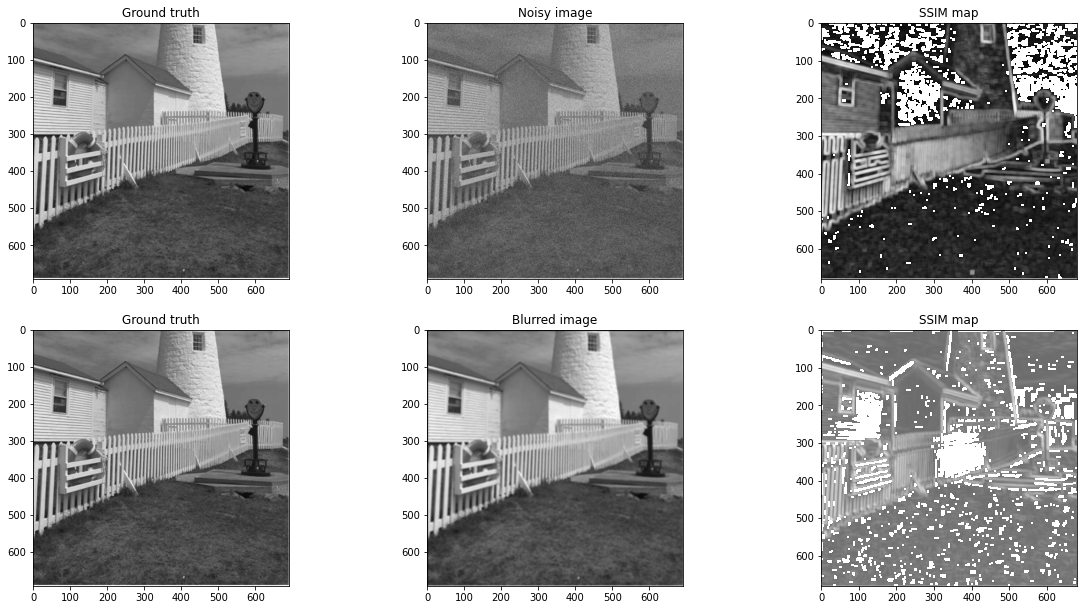

In [5]:
plt.rcParams["figure.figsize"] = (20, 16)

plt.subplot(3, 3, 1)
plt.title("Ground truth")
plt.imshow(img_3, cmap="gray")

plt.subplot(3, 3, 2)
plt.title("Noisy image")
plt.imshow(img_3_noise, cmap="gray")

plt.subplot(3, 3, 3)
plt.title("SSIM map")
plt.imshow(img_3_noise_ssim, cmap="gray")

plt.subplot(3, 3, 4)
plt.title("Ground truth")
plt.imshow(img_3, cmap="gray")

plt.subplot(3, 3, 5)
plt.title("Blurred image")
plt.imshow(img_3_blur, cmap="gray")

plt.subplot(3, 3, 6)
plt.title("SSIM map")
plt.imshow(img_3_blur_ssim, cmap="gray")

# Edge detection

## Gradient Edge Detectors

### Question 1

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


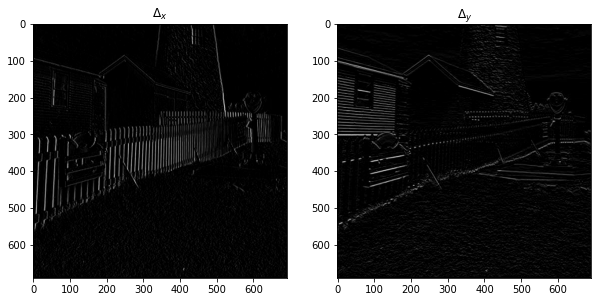

In [6]:
## Centered 2-D differencing
kx = 0.5*np.array([-1, 0, 1]).reshape(1, 3)
ky = kx.T
Dx_a = linear_convolve_dft(img_3, kx)
Dy_a = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_a, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_a, cmap="gray")

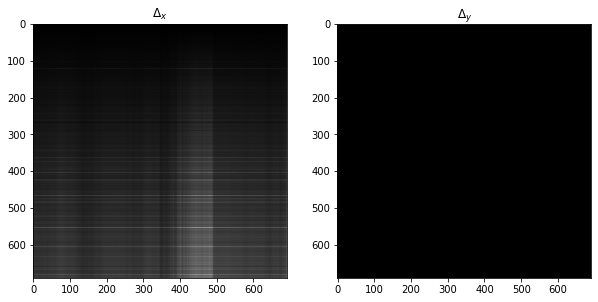

In [47]:
## Roberts operator
kx = np.matrix([[-1, 0], [0, 1]])
ky = np.matrix([[0, -1], [1, 0]])
Dx_b = linear_convolve_dft(img_3, kx)
Dy_b = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_b, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_b, cmap="gray")

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


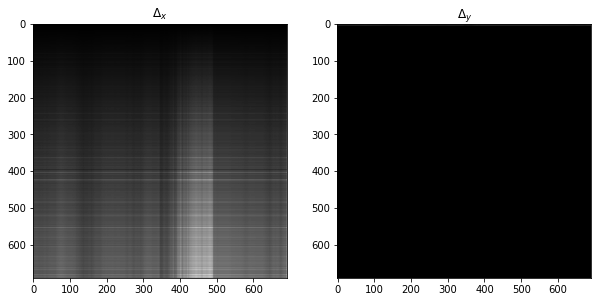

In [8]:
## Prewitt operator
kx = np.matrix([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])/3
ky = kx.T
Dx_c = linear_convolve_dft(img_3, kx)
Dy_c = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_c, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_c, cmap="gray")

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


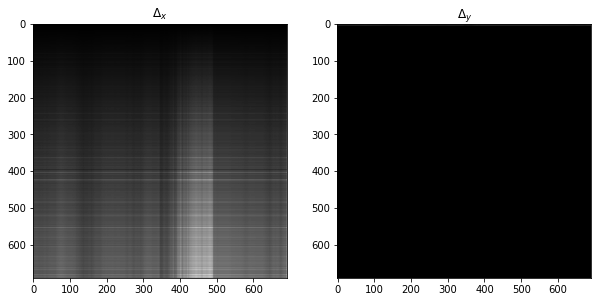

In [9]:
## Sobel differencing
kx = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])/4
ky = kx.T
Dx_d = linear_convolve_dft(img_3, kx)
Dy_d = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_c, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_c, cmap="gray")

### Question 2

In [21]:
## a
M_a = np.sqrt(np.power(Dx_a, 2) + np.power(Dy_a, 2))

In [22]:
## b
M_b = np.absolute(Dx_a) + np.absolute(Dy_a)

In [23]:
## c
M_c = np.maximum(np.absolute(Dx_a), np.absolute(Dy_a))

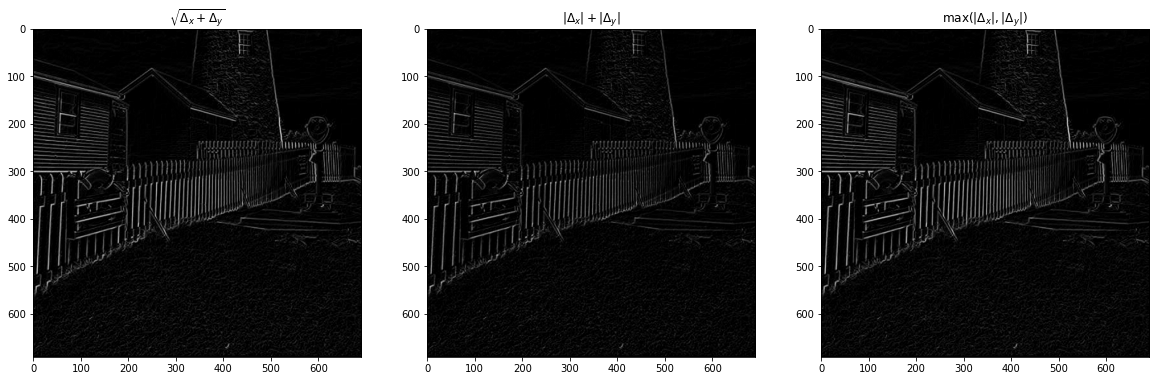

In [25]:
plt.rcParams["figure.figsize"] = (20, 16)

plt.subplot(1, 3, 1)
plt.title(r'$\sqrt{{{\Delta}_x} + {{\Delta}_y}}$')
plt.imshow(M_a, cmap="gray")

plt.subplot(1, 3, 2)
plt.title(r'${|{{\Delta}_x}| + |{{\Delta}_y}|}$')
plt.imshow(M_b, cmap="gray")

plt.subplot(1, 3, 3)
plt.title(r'max($|{{\Delta}_x}|, |{{\Delta}_y}|$)')
plt.imshow(M_c, cmap="gray")

## Laplacian Edge Detectors

### Question 1

In [90]:
K = np.matrix([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
L = linear_convolve_dft(img_3, K)

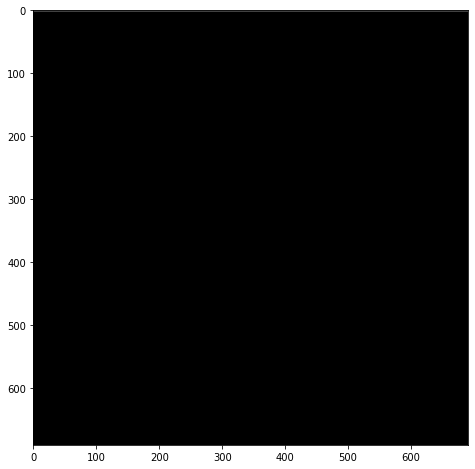

In [91]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.imshow(L, cmap="gray")

### Question 2

In [50]:
def ZC_detection(L):
    M, N = L.shape
    I = np.zeros(L.shape, dtype=int)
    for i in range(M-2):
        for j in range(N-2):
            if L[i, j] > 0:
                if L[i, j+1] < 0:
                    I[i, j+1] = 1
                elif L[i, j+1] == 0:
                    if L[i, j+2] > 0:
                        L[i, j+1] = 0
                if L[i+1, j] < 0:
                    I[i+1, j] = 1
                elif L[i+1, j] == 0:
                    if L[i+2, j] > 0:
                        L[i+1, j] = 0
            elif L[i, j] < 0:
                if L[i, j+1] > 0:
                    I[i, j+1] = 1
                elif L[i, j+1] == 0:
                    if L[i, j+2] < 0:
                        L[i, j+1] = 0
                if L[i+1, j] > 0:
                    I[i+1, j] = 1
                elif L[i+1, j] == 0:
                    if L[i+2, j] < 0:
                        L[i+1, j] = 0
    return I

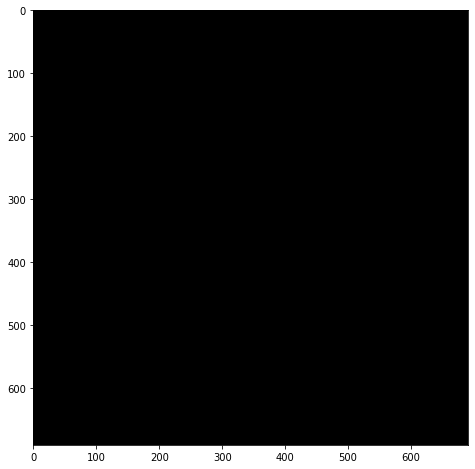

In [53]:
E = ZC_detection(L)
plt.imshow(E, cmap="gray")

## Laplacian of Gaussian(LoG)

In [64]:
def sampled_LoG(sigma, N):
    H = np.zeros((N, N))

    mid = N//2
    for i in range(N):
        for j in range(N):
            H[i, j] = (1 - ((mid-i)**2 + (mid-j)**2)/((N*sigma)**2))*np.exp(-0.5*((mid-i)**2 + (mid-j)**2)/((N*sigma)**2))
    return H/np.sum(H)

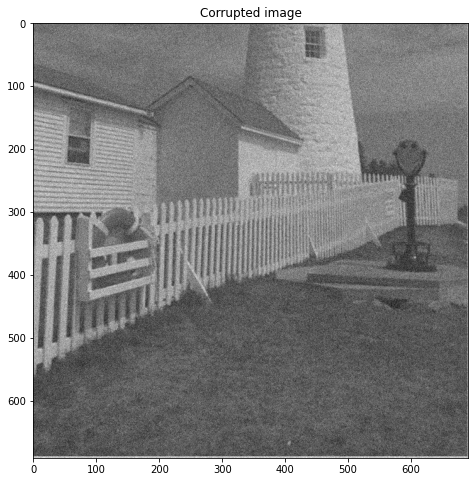

In [84]:
img_3_awgn = img_3 + np.random.normal(0, 0.1, img_3.shape)

plt.title("Corrupted image")
plt.imshow(img_3_awgn, cmap="gray")

In [92]:
sigma = 10
img_3_log = linear_convolve_dft(img_3_awgn, sampled_LoG(sigma, 5))

L = linear_convolve_dft(img_3_log, K)

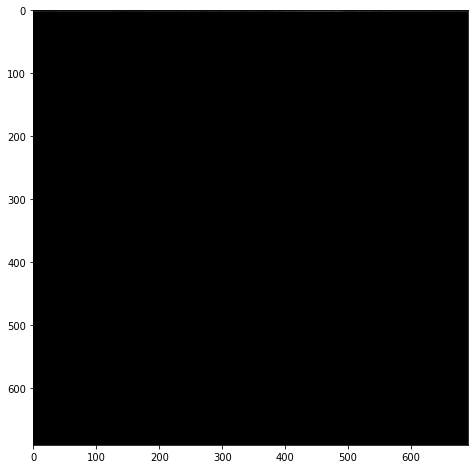

In [93]:
plt.imshow(L, cmap="gray")